<a href="https://colab.research.google.com/github/mkemalgokce/maskDetection-w-CNN/blob/main/maskDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
#Uploading kaggle.json
from google.colab import files

files.upload()

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


### Downloading Datasets

In [3]:
!kaggle datasets download -d ashwingupta3012/human-faces
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset

100% 1.82G/1.82G [00:15<00:00, 47.8MB/s]
100% 1.82G/1.82G [00:15<00:00, 126MB/s] 
 97% 321M/330M [00:09<00:00, 41.6MB/s]
100% 330M/330M [00:09<00:00, 35.6MB/s]


In [4]:
import numpy as np 
import matplotlib.pyplot as plt 
import shutil
import os 
import zipfile 
import random
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import tensorflow as tf

# **Unzipping Datasets**

In [5]:
local_zip = '/content/face-mask-12k-images-dataset.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/content/face_mask_datas')
zip_ref.close()

local_zip = '/content/human-faces.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/content/human-faces')
zip_ref.close()

shutil.rmtree('/content/face_mask_datas/Face Mask Dataset/Train/WithoutMask')
os.mkdir('/content/face_mask_datas/Face Mask Dataset/Train/WithoutMask')

## **Preproccesing Datas**

I will shuffle this datasets. For mask datas, I will use Human Faces Datasets.

In [6]:
HUMANS_DIR = '/content/human-faces/Humans'
FACE_MASK_DIR = '/content/face_mask_datas/Face Mask Dataset'

print('Len Humans Dataset :', len(os.listdir(HUMANS_DIR)))
print('Len With Mask Dataset :',len(os.listdir(FACE_MASK_DIR+'/Train/'+'WithMask/')))


Len Humans Dataset : 7219
Len With Mask Dataset : 5000


**As you can see, we have 5000 images with mask and we have 7219 images without mask.**

In [7]:
lenSource = len(os.listdir(HUMANS_DIR))
sourceArray = os.listdir(HUMANS_DIR)
for i in range(lenSource):
    shutil.copyfile(HUMANS_DIR+'/'+sourceArray[i],FACE_MASK_DIR+'/Train/WithoutMask/'+sourceArray[i])


## Showing Datas

This cell shows random images from our dataset.

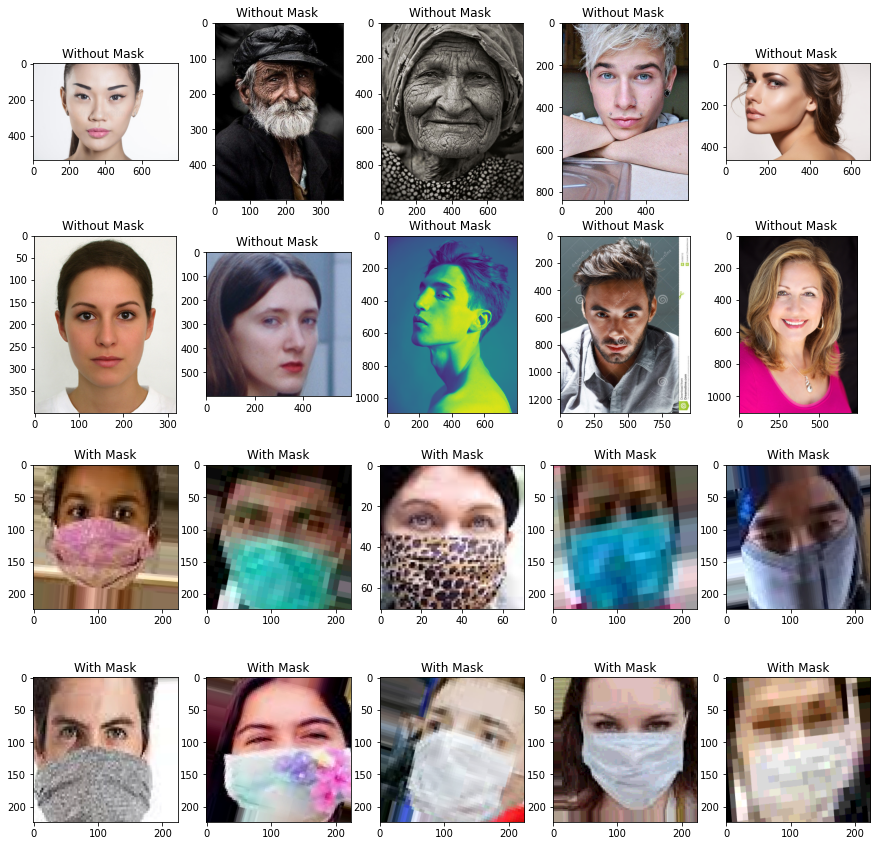

In [46]:
plt.figure(figsize=(15,15))
for i in range(1,21):
  plt.subplot(4,5,i)
  if(i > 10):
    plt.title('With Mask')
    img = plt.imread(FACE_MASK_DIR+'/Train/WithMask/'+os.listdir(FACE_MASK_DIR+'/Train/WithMask/')[random.randint(0,200)])
  else:
    plt.title('Without Mask ')
    img = plt.imread(FACE_MASK_DIR+'/Train/WithoutMask/'+os.listdir(FACE_MASK_DIR+'/Train/WithoutMask/')[random.randint(0,200)])
  plt.imshow(img)

## Creating Generators

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAINING_DIR = '/content/face_mask_datas/Face Mask Dataset/Train'
train_datagen = ImageDataGenerator(rescale=1/255.,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=32,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = '/content/face_mask_datas/Face Mask Dataset/Validation'
validation_datagen = ImageDataGenerator(rescale=1/255.)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                  batch_size=32,
                                                  class_mode='binary',
                                                  target_size=(150, 150))

                                                  

Found 12219 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


# Creating Model

In [11]:
from keras.applications.vgg19 import VGG19

# I used transfer learning.
vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(150,150,3))

for layer in vgg19.layers:
    layer.trainable = False
    
model = tf.keras.models.Sequential()
model.add(vgg19)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 8193      
Total params: 20,032,577
Trainable params: 8,193
Non-trainable params: 20,024,384
_________________________________________________________________


In [12]:
model.compile(loss = "binary_crossentropy",
             optimizer = 'adam',
             metrics = ["acc"])

In [13]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator)//32,
                    epochs=50,
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator)//32)

Epoch 1/50
11/11 [==============================] - 38s 605ms/step - loss: 0.6184 - acc: 0.6465
Epoch 2/50
11/11 [==============================] - 9s 804ms/step - loss: 0.3614 - acc: 0.8626
Epoch 3/50
11/11 [==============================] - 7s 583ms/step - loss: 0.2321 - acc: 0.9332
Epoch 4/50
11/11 [==============================] - 6s 561ms/step - loss: 0.2184 - acc: 0.9161
Epoch 5/50
11/11 [==============================] - 7s 674ms/step - loss: 0.1899 - acc: 0.9399
Epoch 6/50
11/11 [==============================] - 7s 643ms/step - loss: 0.1939 - acc: 0.9157
Epoch 7/50
11/11 [==============================] - 5s 502ms/step - loss: 0.2034 - acc: 0.9074
Epoch 8/50
11/11 [==============================] - 8s 750ms/step - loss: 0.1511 - acc: 0.9693
Epoch 9/50
11/11 [==============================] - 7s 629ms/step - loss: 0.1793 - acc: 0.9353
Epoch 10/50
11/11 [==============================] - 8s 722ms/step - loss: 0.1804 - acc: 0.9164
Epoch 11/50
11/11 [=============================

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


11/11 [==============================] - 7s 655ms/step - loss: 0.0971 - acc: 0.9680
Epoch 24/50
11/11 [==============================] - 8s 608ms/step - loss: 0.1446 - acc: 0.9506
Epoch 25/50
11/11 [==============================] - 7s 640ms/step - loss: 0.1001 - acc: 0.9600
Epoch 26/50
11/11 [==============================] - 7s 607ms/step - loss: 0.1049 - acc: 0.9713
Epoch 27/50
11/11 [==============================] - 9s 839ms/step - loss: 0.1008 - acc: 0.9732
Epoch 28/50
11/11 [==============================] - 6s 586ms/step - loss: 0.1073 - acc: 0.9660
Epoch 29/50
11/11 [==============================] - 6s 525ms/step - loss: 0.1023 - acc: 0.9671
Epoch 30/50
11/11 [==============================] - 8s 764ms/step - loss: 0.0877 - acc: 0.9624
Epoch 31/50
11/11 [==============================] - 9s 789ms/step - loss: 0.1279 - acc: 0.9495
Epoch 32/50
11/11 [==============================] - 8s 711ms/step - loss: 0.1101 - acc: 0.9524
Epoch 33/50
11/11 [==============================] -

# Testing Models





In [30]:
import cv2
imgs = np.zeros((200,150,150,3))
for i in range(200):
    if(i <100):
      img = os.listdir('/content/face_mask_datas/Face Mask Dataset/Test/WithMask/')[i]
      img = cv2.imread('/content/face_mask_datas/Face Mask Dataset/Test/WithMask/'+img)
    else:
      img = os.listdir('/content/face_mask_datas/Face Mask Dataset/Test/WithoutMask/')[i]
      img = cv2.imread('/content/face_mask_datas/Face Mask Dataset/Test/WithoutMask/'+img)
    img = cv2.resize(img,(150,150)) / 255.0
    imgs[i] = img


### Showing Results

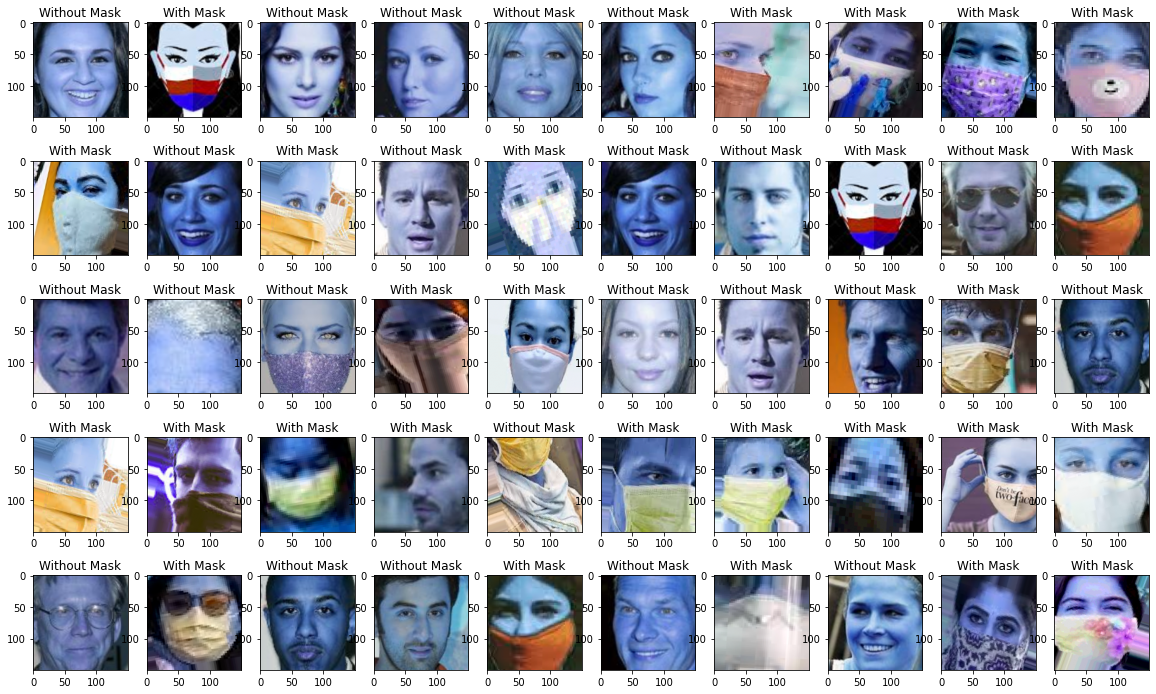

In [45]:
predicts = model.predict(imgs)
plt.figure(figsize=(20,25))
for i in range(1,51):
    plt.subplot(10,10,i)
    val = random.randint(0,200)
    if(predicts[val]<0.5):
      plt.title('With Mask')
    else:
      plt.title('Without Mask')
    plt.imshow(imgs[val])

# Plotting History

Text(0.5, 1.0, 'Training and validation loss')

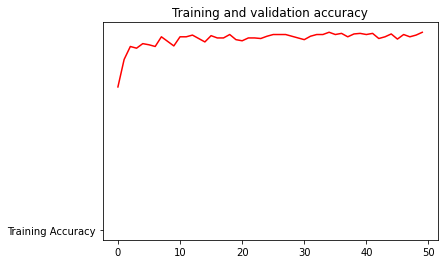

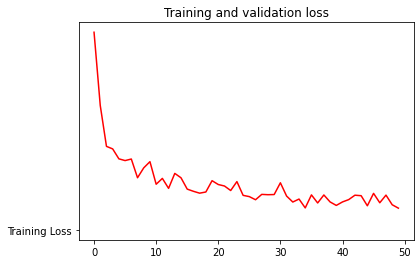

In [40]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

acc=history.history['acc']
loss=history.history['loss']

epochs=range(len(acc)) # Get number of epochs

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

plt.plot(epochs, loss, 'r', "Training Loss")


plt.title('Training and validation loss')

# **Saving Model**

In [48]:
model.save('/tmp/mymodel.h5')